# Filter analysis of Convolutional Layers

This notebook investigates features were learned by filters in the convolutional layers in a conv. network. Especially we are interested in the features learned by filters that show a higher average activity for inputs of a certain class. In this case the network was trained on 128 electrode EEG data to discriminate between 4 classes (right hand, left hand, rest, right foot).

To find the fiters of interest the data it was trained on (1720 trials / 430 per class) was run through the network and the average activity over all units in a filter over all inputs for a certain class was recorded. The mean activity of the filters regarding a single class was then compared with the average activity for the remaining classes to find the on average most active filters for a certain class.

The 200 trials that invoked the highest response in a unit of a filter (top 46% of class trials) were determined and the signal window that was responsible for activity in that unit (receptive field of the unit on the total input) was recorded. Several features are then extracted from those windows and their distribution is compared to a baseline of (randomly) sampled control inputs also belonging to one of the 4 classes.

The deeper the layer in the convolutional network, the bigger the receptive field of its units and more complex characteristic features are expected.

In this notebook class 0 is compared to the other classes

In [1]:
cl = 0
max_baseline_inputs = 2000 # Number of signal windows used for baseline

In [2]:
import numpy as np
import scipy

import logging
log = logging.getLogger()
log.setLevel("DEBUG")
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

from braindecode.veganlasagne.layer_util import print_layers

import os
from numpy.random import RandomState

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5005)
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
import receptive_field
import analysis
import utils

In [5]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'
RF_save = receptive_field.ReceptiveFieldInputsIO()

In [6]:
rng = RandomState(98787)

In [7]:
# Plotting functions
def cut_input_data(RF_data,filt,separated_channels=True,use_class_start_samples=False):
    reshape_channels = n_chans
    if separated_channels:
        reshape_channels = 1
    
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    filt_input_indeces = max_units_in_filters[:,1]==filt
    max_units_in_filters = max_units_in_filters[filt_input_indeces]
    
    X_RF_cropped = utils.get_cropped_RF(RF_data.results[cl].RF_X[filt_input_indeces].squeeze(),([0],reshape_channels,-1))
    window_indeces = np.unique(max_units_in_filters[:,2])
    
    inputs_baseline = RF_data.results[cl].inputs
    if use_class_start_samples:
        X_baseline = utils.cut_ind_windows(inputs_baseline,X_RF_cropped.shape[2],window_indeces,wins_per_input=10).squeeze()
    else:
        X_baseline = utils.cut_rand_windows(inputs_baseline,X_RF_cropped.shape[2],10).squeeze()
    
    if seperated_channels:
        X_baseline = X_baseline.reshape((-1,X_RF_cropped.shape[1],X_RF_cropped.shape[2]))
        
    indx = rng.permutation(len(X_baseline))[:max_baseline_inputs]
    X_baseline = X_baseline[indx]
    
    return X_RF_cropped,X_baseline 
    

def plot_max_filters(RF_data):
    print 'Max filters: ',RF_data.results[cl].max_filters
    plt.figure()
    sns.heatmap(np.reshape(RF_data.results[cl].filters_means,(-1,1)).T,
                linewidths=.5)
    plt.xlabel('Filter #')
    plt.ylabel('Activation Diff')
    plt.title('Mean activation for feature maps over all inputs')
    plt.show()
    
    
def print_features(score,p,labels,indeces):
    for idx in indeces:
        print 'Score %f  p %f  : %s'%(score[idx],p[idx],labels[idx])
        
        
def plot_RF_starts(RF_data,win_size):
    plt.figure()
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    max_units_in_filters = max_units_in_filters[max_units_in_filters[:,1]==filt]
    sns.distplot(max_units_in_filters[:,2],bins=np.arange(0,RF_data.results[cl].inputs.shape[2],20),kde=False)
    plt.xlim([1,RF_data.results[cl].inputs.shape[2]-win_size])
    plt.xlabel('Sample #')
    plt.ylabel('Number of receptive fields starting at sample')
    plt.title('Starting of the RF windows in complete input signal')
    plt.show()
    
    
def plot_channels(RF_data,sensor_names):
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    max_units_in_filters = max_units_in_filters[max_units_in_filters[:,1]==filt]
    chan_counts = np.bincount(max_units_in_filters[:,3])
    max_chan = chan_counts.argmax()
    max_name = sensor_names[max_chan]
    plt.figure()
    sns.distplot(max_units_in_filters[:,3],bins=np.arange(n_chans),kde=False)
    plt.xlim([0,n_chans])
    plt.ylabel('Number of times signal window originated in channel')
    plt.xlabel('Channel #')
    plt.title('Channels that provided maximized input %s: %d'%(max_name,chan_counts[max_chan]))
    plt.show()
        
        
def plot_channel_avg(X_RF_cropped,channel,title=''):
    plt.figure()
    sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_points")
    m = X_RF_cropped[:,channel].mean(axis=0)
    s = X_RF_cropped[:,channel].std(axis=0)
    plt.fill_between(np.arange(X_RF_cropped.shape[2]),m-s,m+s,color='r',zorder=100,alpha=0.3) 
    plt.plot(np.arange(X_RF_cropped.shape[2]),m,color='r',zorder=101) 
    plt.xlabel('Sample #')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()
    

def plot_channel_avg_comparison(X1,X2,channel):
    plt.figure()
    #sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_traces")
    sns.tsplot(data=X1[:,channel],err_style="unit_traces")
    sns.tsplot(data=X2[:,channel],err_style="unit_traces")
    plt.show()
    
    
def plot_dist_comparison(features,features_base,idx):
    sns.distplot(features[:,idx],label='Input')
    sns.distplot(features_base[:,idx],label='Baseline')
    plt.legend()
    plt.xlabel(labels[idx])
    plt.show()
    
    
def subplots_4_features(features,features_base,indeces):
    plt.figure()
    plt.subplot(221)
    plot_dist_comparison(features,features_base,indeces[0])
    plt.subplot(222)
    plot_dist_comparison(features,features_base,indeces[1])
    plt.subplot(223)
    plot_dist_comparison(features,features_base,indeces[2])
    plt.subplot(224)
    plot_dist_comparison(features,features_base,indeces[3])

# Layer 03

Analysis of filters in Layer 03

In [8]:
filename = 'Layer03_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_03 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [13 20 22 18  2]


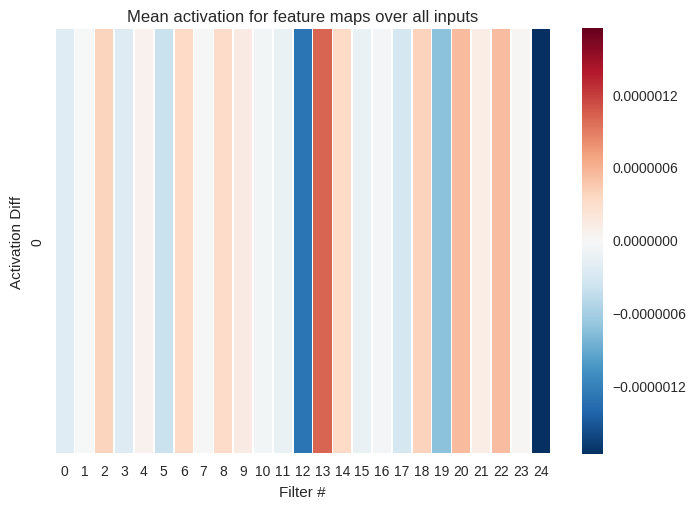

In [9]:
plot_max_filters(RF_data_03)

<b>Filter to look at</b> (index in Max filters)

In [10]:
filt = 1

In [11]:
n_chans = RF_data_03.results[cl].n_chans
sampling_rate = RF_data_03.results[cl].sampling_rate
sensor_names = RF_data_03.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_03,filt,separated_channels=True)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

sensor_names_one_chan = ['N/A' for entry in sensor_names]
feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names_one_chan],
                                    'FFTc':[frequencies,sensor_names_one_chan],
                                    'Phase':[frequencies[1:],sensor_names_one_chan],
                                    'Phasec':[frequencies[1:],sensor_names_one_chan],
                                    'Mean':[sensor_names_one_chan],
                                    'Meanc':[sensor_names_one_chan]})

In [12]:
print X_RF_cropped.shape

(200, 1, 10)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

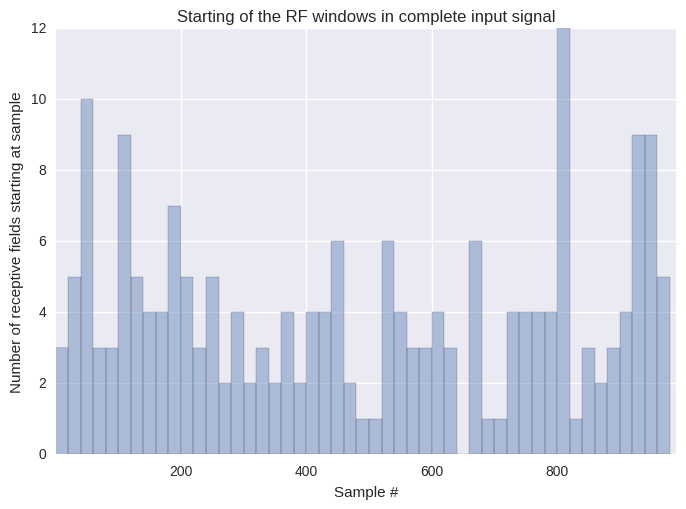

In [13]:
plot_RF_starts(RF_data_03,X_baseline.shape[2])

### Channels of the Receptive Field
In Layer 03 the receptive field is still channel specific. Therefore it could be interesting to see from which channel the most maximizing signal windows originate

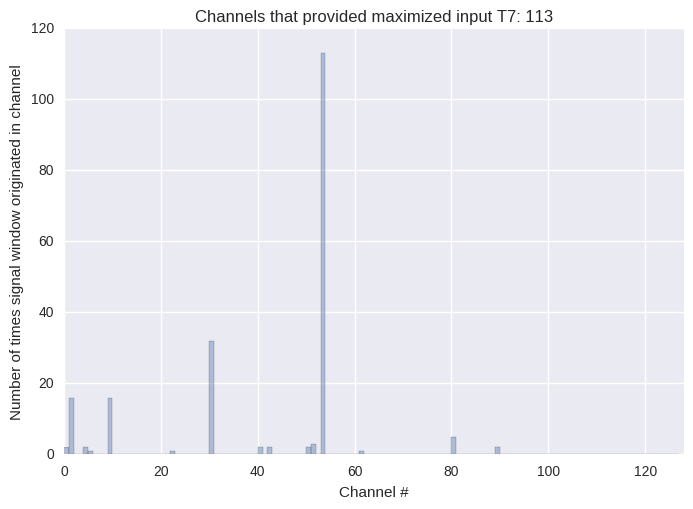

In [14]:
plot_channels(RF_data_03,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

There are no channel specific features in L03, because the features are extracted for the one channel in the receptive field.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [15]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.991000  p 0.000000  : FFT 75.0 N/A
Score 0.976000  p 0.000000  : FFT 50.0 N/A
Score 0.946000  p 0.000000  : FFT 100.0 N/A
Score 0.901000  p 0.000000  : FFT 25.0 N/A
Score 0.772000  p 0.000000  : FFTc 25.0 N/A
Score 0.741000  p 0.000000  : Phase 50.0 N/A
Score 0.737000  p 0.000000  : Meanc N/A
Score 0.698000  p 0.000000  : Phase 100.0 N/A
Score 0.667000  p 0.000000  : FFTc 0.0 N/A
Score 0.562000  p 0.000000  : Phase 75.0 N/A
Score 0.537000  p 0.000000  : Phase 25.0 N/A
Score 0.319000  p 0.000000  : Phasec 25.0 N/A
Score 0.215000  p 0.000000  : FFT 0.0 N/A
Score 0.191000  p 0.000008  : Mean N/A


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

(200, 14) (1000, 14)


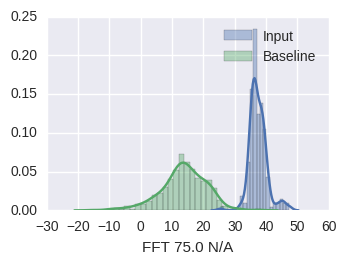

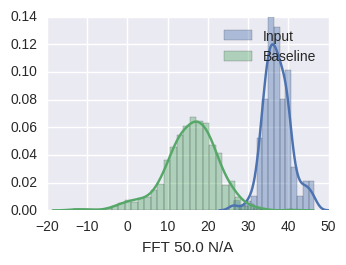

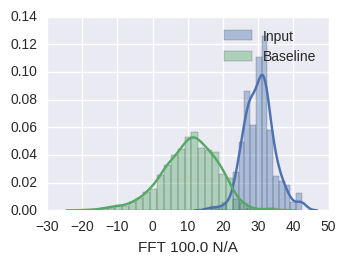

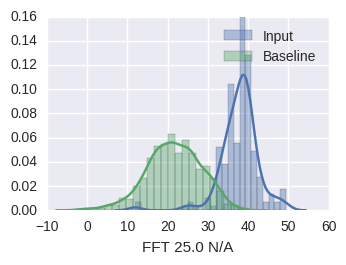

In [16]:
print features_class.shape,features_base.shape
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

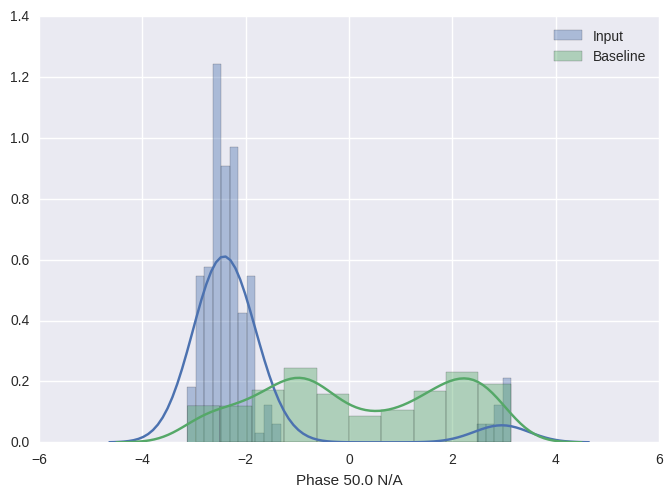

In [17]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[5])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows.  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [18]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [3, 0]] ['FFT', [2, 0]] ['FFT', [4, 0]] ['FFT', [1, 0]]
 ['FFTc', [1, 0]] ['Phase', [1, 0]] ['Meanc', [0]] ['Phase', [3, 0]]
 ['FFTc', [0, 0]] ['Phase', [2, 0]]]


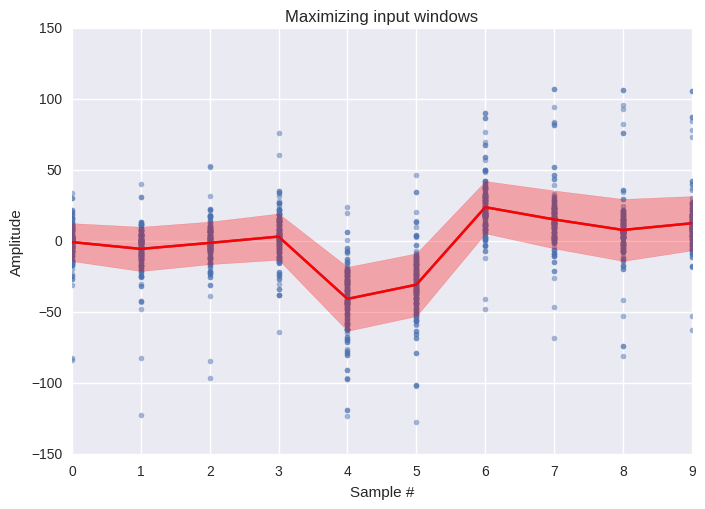

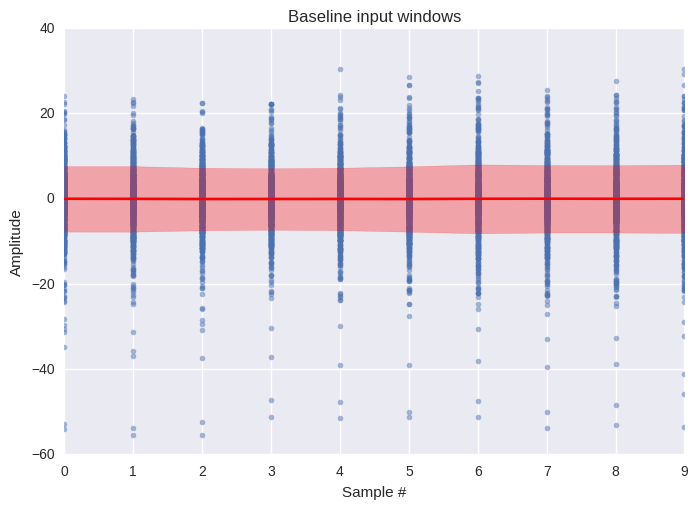

In [19]:
plot_channel_avg(X_RF_cropped,0,'Maximizing input windows')
plot_channel_avg(X_baseline,0,'Baseline input windows')

# Layer 04

Analysis of filters in Layer 04

In [20]:
filename = 'Layer04_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_04 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [24 12 20 13 14]


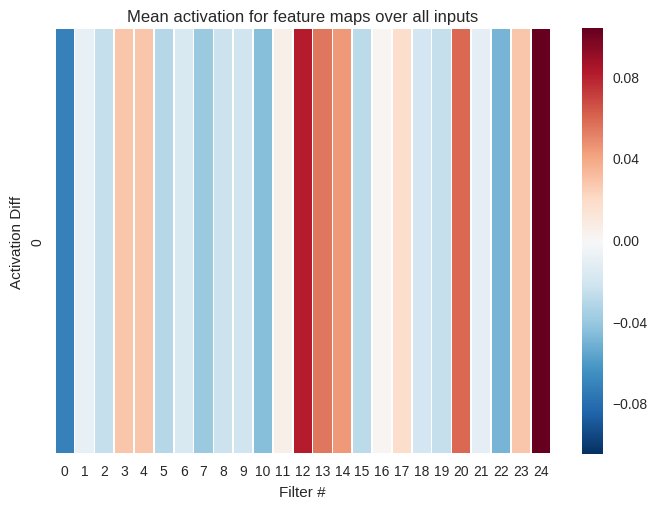

In [21]:
plot_max_filters(RF_data_04)

<b>Filter to look at</b> (index in Max filters)

In [22]:
filt = 1

In [23]:
n_chans = RF_data_04.results[cl].n_chans
sampling_rate = RF_data_04.results[cl].sampling_rate
sensor_names = RF_data_04.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_04,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

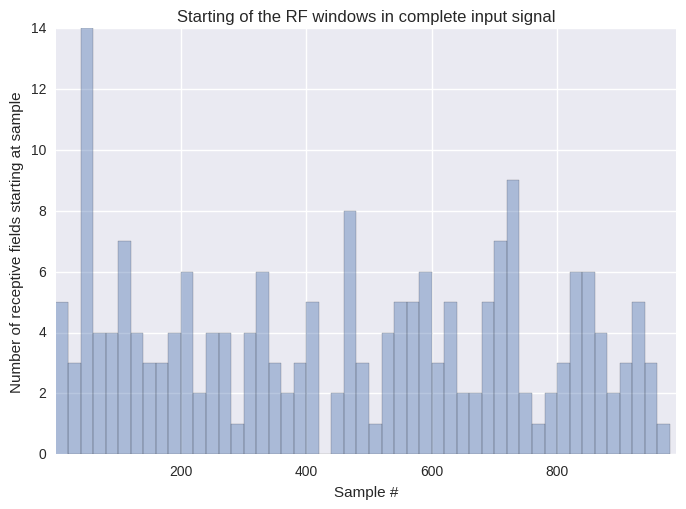

In [24]:
plot_RF_starts(RF_data_04,X_baseline.shape[2])

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [25]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.391000  p 0.000000  : Phase 75.0 FCz
Score 0.386000  p 0.000000  : Phase 75.0 FFC2h
Score 0.349000  p 0.000000  : Phase 75.0 FC2
Score 0.334000  p 0.000000  : Phase 75.0 FCC2h
Score 0.325000  p 0.000000  : Phase 75.0 FFC1h
Score 0.317000  p 0.000000  : Phase 75.0 FC1
Score 0.314000  p 0.000000  : Phase 75.0 FCC1h
Score 0.314000  p 0.000000  : Phase 75.0 F2
Score 0.300000  p 0.000000  : Phase 75.0 C3
Score 0.295000  p 0.000000  : Phase 75.0 FC6
Score 0.294000  p 0.000000  : Phase 75.0 C2
Score 0.293000  p 0.000000  : Phase 75.0 C4
Score 0.291000  p 0.000000  : Phase 75.0 FFC4h
Score 0.285000  p 0.000000  : Phase 75.0 P9
Score 0.283000  p 0.000000  : Phase 75.0 FC4
Score 0.278000  p 0.000000  : Phase 25.0 FTT8h
Score 0.278000  p 0.000000  : Meanc FTT8h
Score 0.276000  p 0.000000  : Phase 75.0 CCP2h
Score 0.269000  p 0.000000  : Phase 75.0 FCC6h
Score 0.269000  p 0.000000  : Phase 75.0 I1


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

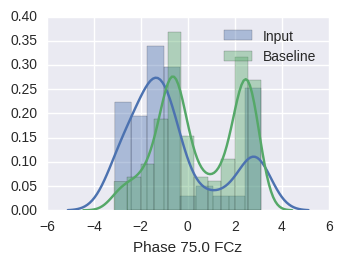

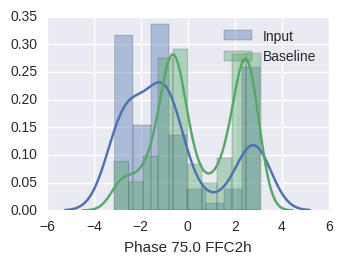

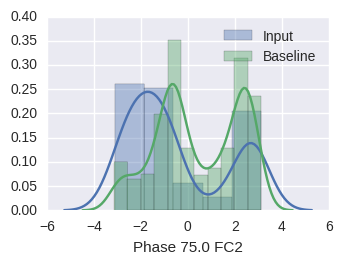

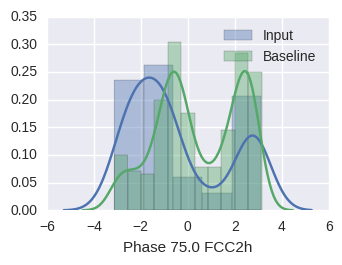

In [26]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

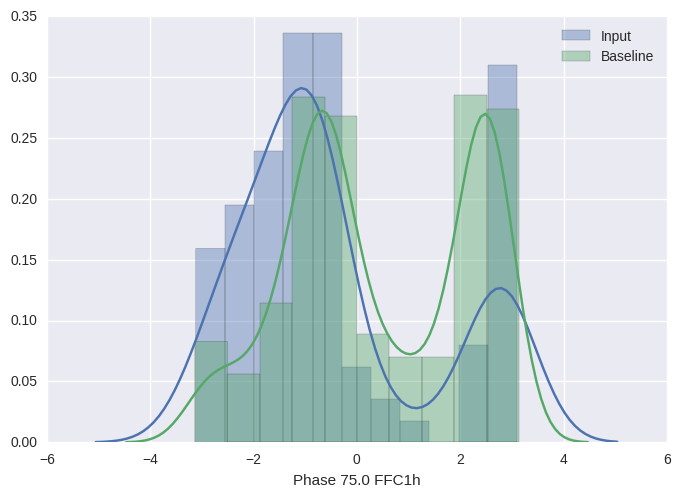

In [27]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[4])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [28]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [2, 36]] ['Phase', [2, 27]] ['Phase', [2, 37]]
 ['Phase', [2, 47]] ['Phase', [2, 26]] ['Phase', [2, 35]]
 ['Phase', [2, 46]] ['Phase', [2, 19]] ['Phase', [2, 55]]
 ['Phase', [2, 39]]]


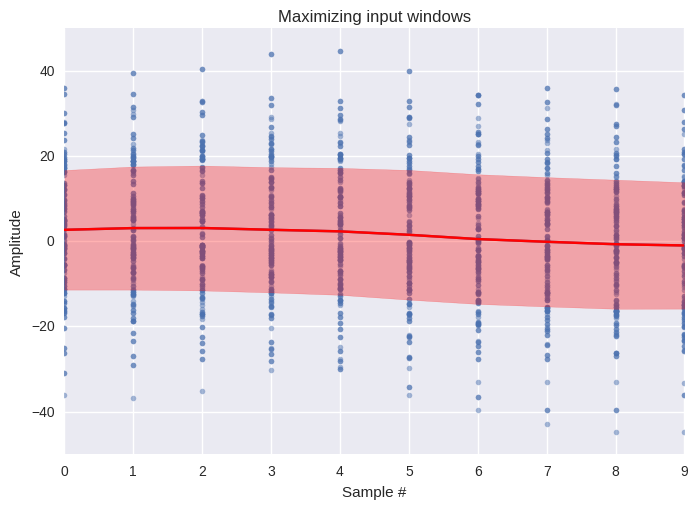

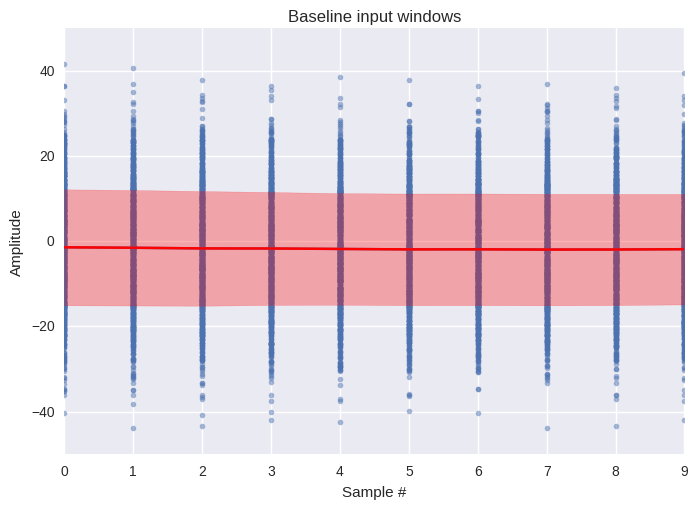

In [29]:
plot_channel_avg(X_RF_cropped,75,'Maximizing input windows')
plot_channel_avg(X_baseline,75,'Baseline input windows')

# Layer 10

Analysis of filters in Layer 10

In [30]:
filename = 'Layer10_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_10 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [25 49 16 27 11]


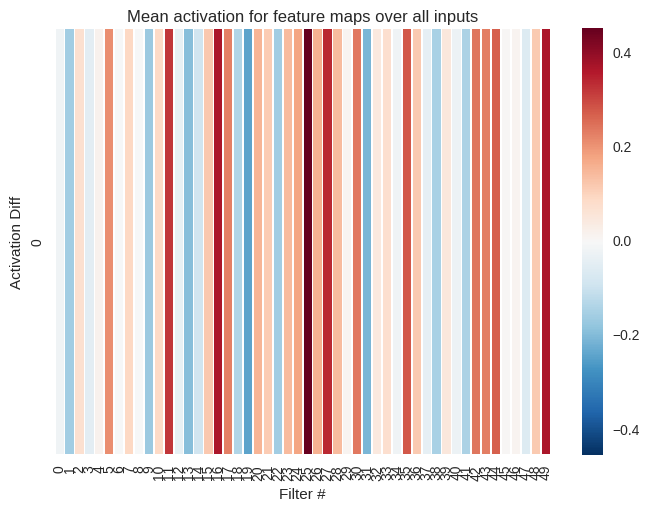

In [31]:
plot_max_filters(RF_data_10)

<b>Filter to look at</b> (index in Max filters)

In [32]:
filt = 1

In [33]:
n_chans = RF_data_10.results[cl].n_chans
sampling_rate = RF_data_10.results[cl].sampling_rate
sensor_names = RF_data_10.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_10,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

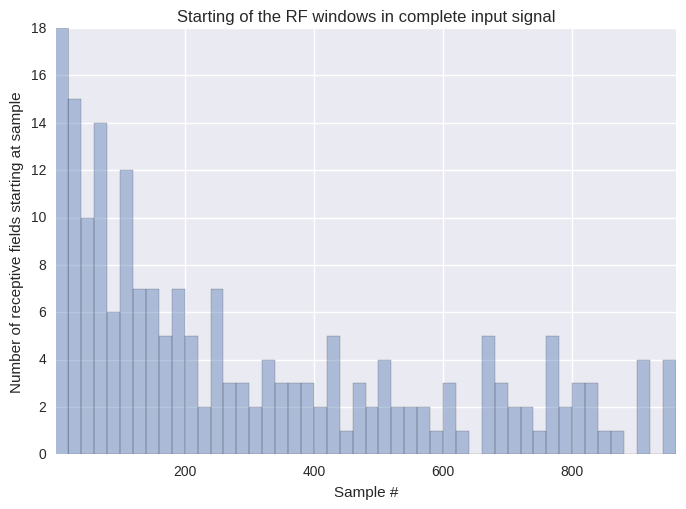

In [34]:
plot_RF_starts(RF_data_10,X_baseline.shape[2])

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [35]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.474000  p 0.000000  : Phase 12.8205128205 FCC6h
Score 0.457000  p 0.000000  : Phase 12.8205128205 C4
Score 0.435000  p 0.000000  : Phase 12.8205128205 FCC4h
Score 0.392000  p 0.000000  : Phasec 6.41025641026 FC4
Score 0.383000  p 0.000000  : Phasec 6.41025641026 FCC4h
Score 0.380000  p 0.000000  : Phase 12.8205128205 CP6
Score 0.376000  p 0.000000  : Phase 12.8205128205 C6
Score 0.376000  p 0.000000  : Phase 12.8205128205 CPP6h
Score 0.372000  p 0.000000  : Phase 12.8205128205 FC4
Score 0.368000  p 0.000000  : Phase 12.8205128205 FCC3h
Score 0.362000  p 0.000000  : Phase 12.8205128205 FC3
Score 0.361000  p 0.000000  : Phasec 38.4615384615 FCC4h
Score 0.360000  p 0.000000  : Phase 12.8205128205 CCP6h
Score 0.348000  p 0.000000  : Phasec 6.41025641026 C4
Score 0.344000  p 0.000000  : Phasec 19.2307692308 FCC4h
Score 0.342000  p 0.000000  : Phasec 6.41025641026 FCC6h
Score 0.336000  p 0.000000  : Phase 12.8205128205 P6
Score 0.334000  p 0.000000  : Phase 12.8205128205 TTP8h
Score 

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

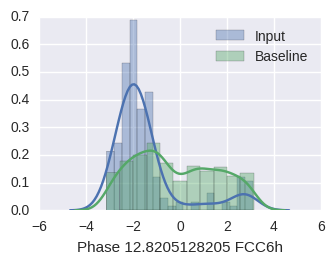

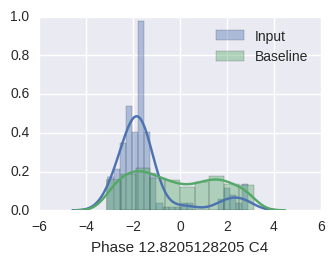

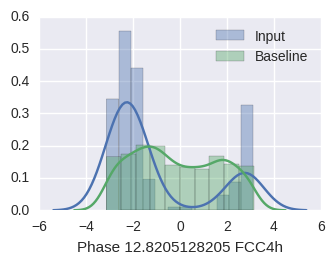

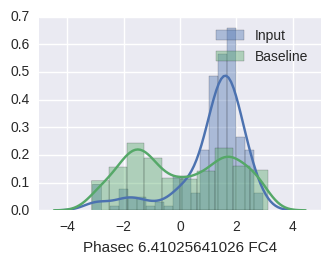

In [36]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

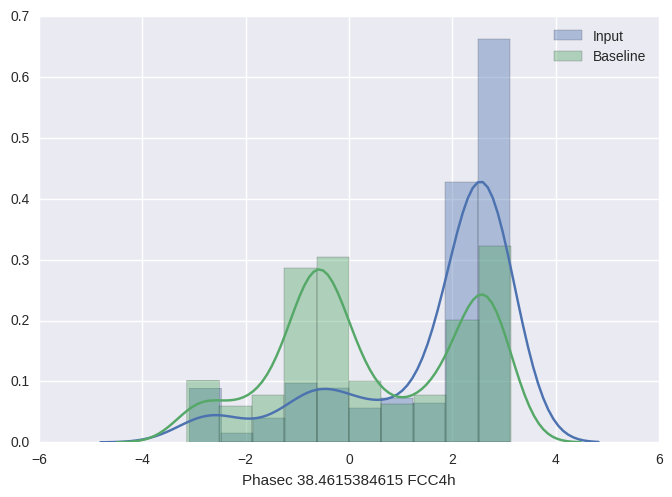

In [37]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[11])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [38]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [1, 49]] ['Phase', [1, 59]] ['Phase', [1, 48]]
 ['Phasec', [0, 38]] ['Phasec', [0, 48]] ['Phase', [1, 78]]
 ['Phase', [1, 60]] ['Phase', [1, 87]] ['Phase', [1, 38]]
 ['Phase', [1, 45]]]


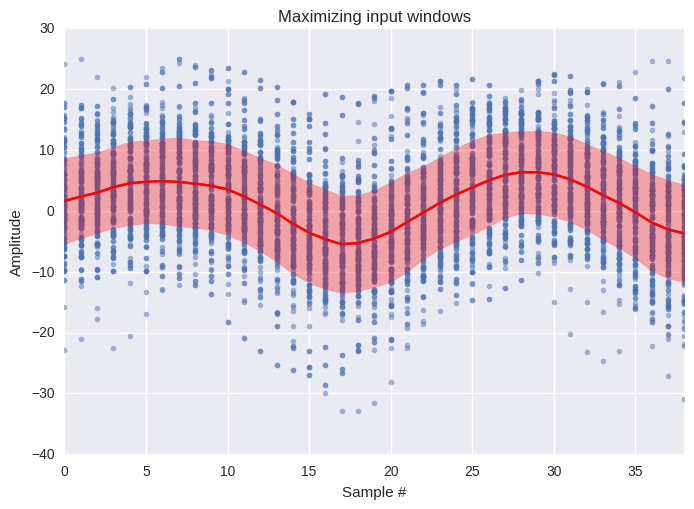

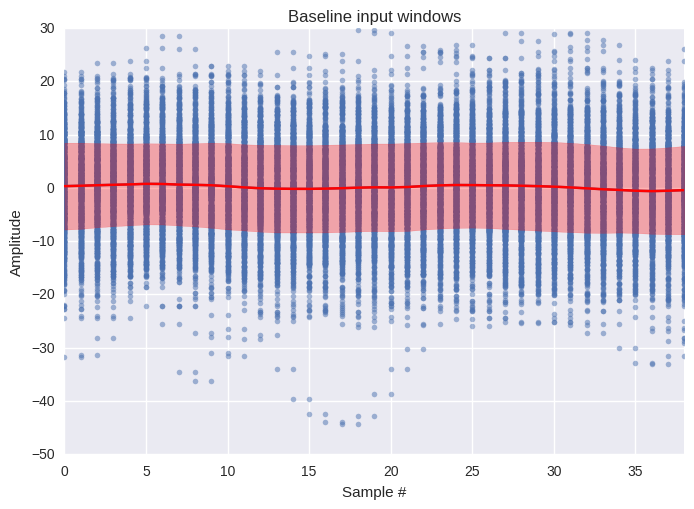

In [39]:
plot_channel_avg(X_RF_cropped,48,'Maximizing input windows')
plot_channel_avg(X_baseline,48,'Baseline input windows')

# Layer 16

Analysis of filters in Layer 16

In [40]:
filename = 'Layer16_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_16 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [70 62 76 55 88]


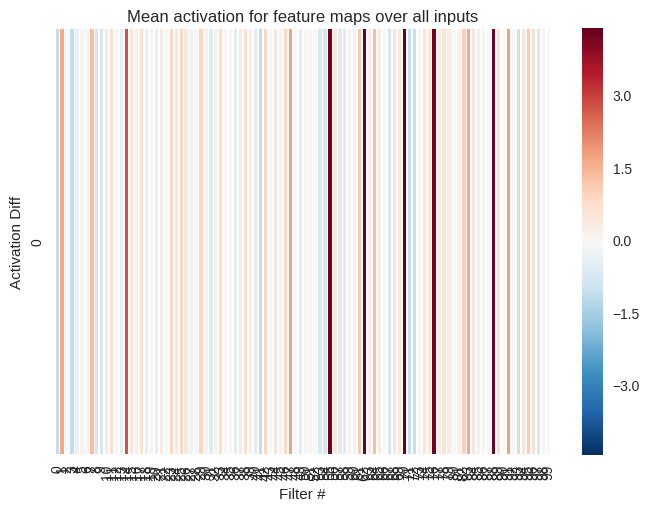

In [41]:
plot_max_filters(RF_data_16)

<b>Filter to look at</b> (index in Max filters)

In [42]:
filt = 1

In [43]:
n_chans = RF_data_16.results[cl].n_chans
sampling_rate = RF_data_16.results[cl].sampling_rate
sensor_names = RF_data_16.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_16,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

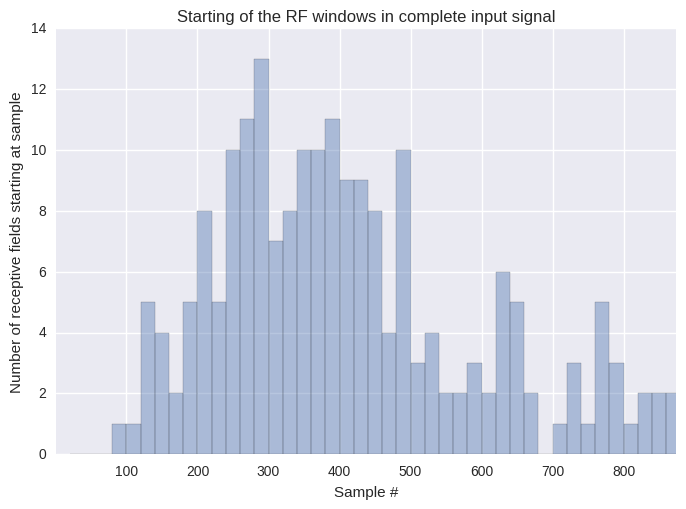

In [44]:
plot_RF_starts(RF_data_16,X_baseline.shape[2])

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [45]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.574000  p 0.000000  : Phase 11.9047619048 FCC4h
Score 0.545000  p 0.000000  : Phase 11.9047619048 FC4
Score 0.499000  p 0.000000  : Phase 11.9047619048 FFC4h
Score 0.495000  p 0.000000  : Phase 11.9047619048 FC2
Score 0.491000  p 0.000000  : Phase 11.9047619048 FCC2h
Score 0.458000  p 0.000000  : Phase 11.9047619048 C4
Score 0.435000  p 0.000000  : Phase 11.9047619048 C2
Score 0.425000  p 0.000000  : FFT 13.8888888889 C3
Score 0.418000  p 0.000000  : FFT 11.9047619048 C3
Score 0.402000  p 0.000000  : Phase 11.9047619048 FCC6h
Score 0.401000  p 0.000000  : Phase 11.9047619048 FFC6h
Score 0.397000  p 0.000000  : Phase 11.9047619048 F2
Score 0.393000  p 0.000000  : FFT 13.8888888889 CP3
Score 0.387000  p 0.000000  : Phase 11.9047619048 FFC2h
Score 0.383000  p 0.000000  : FFTc 5.95238095238 C3
Score 0.368000  p 0.000000  : FFT 13.8888888889 CCP3h
Score 0.364000  p 0.000000  : FFT 13.8888888889 CCP5h
Score 0.364000  p 0.000000  : FFT 11.9047619048 C1
Score 0.363000  p 0.000000  : FF

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

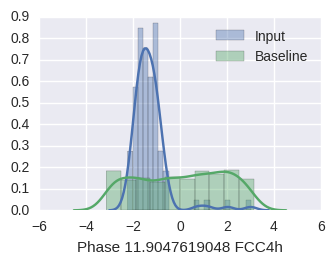

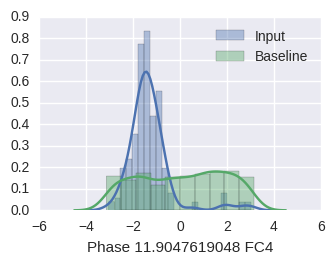

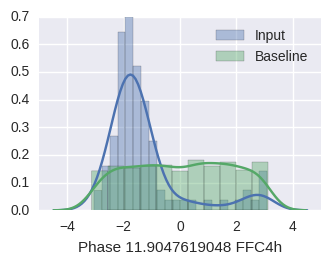

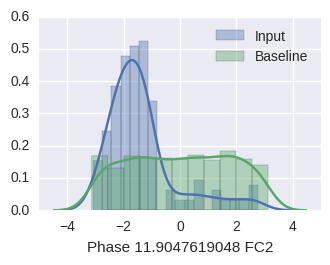

In [46]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

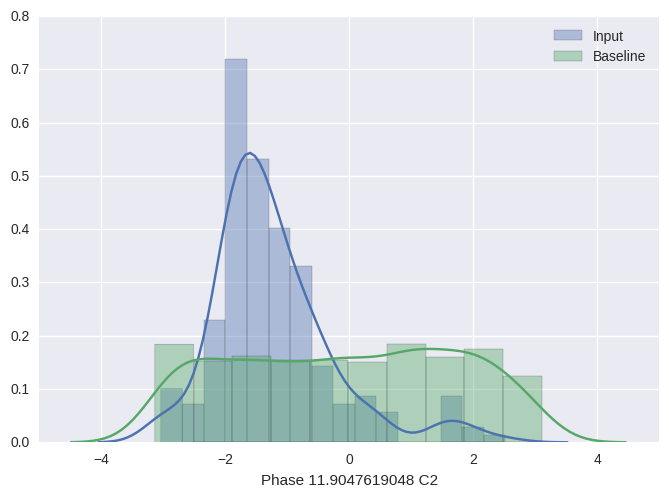

In [47]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[6])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [48]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [5, 48]] ['Phase', [5, 38]] ['Phase', [5, 28]]
 ['Phase', [5, 37]] ['Phase', [5, 47]] ['Phase', [5, 59]]
 ['Phase', [5, 58]] ['FFT', [7, 55]] ['FFT', [6, 55]] ['Phase', [5, 49]]]


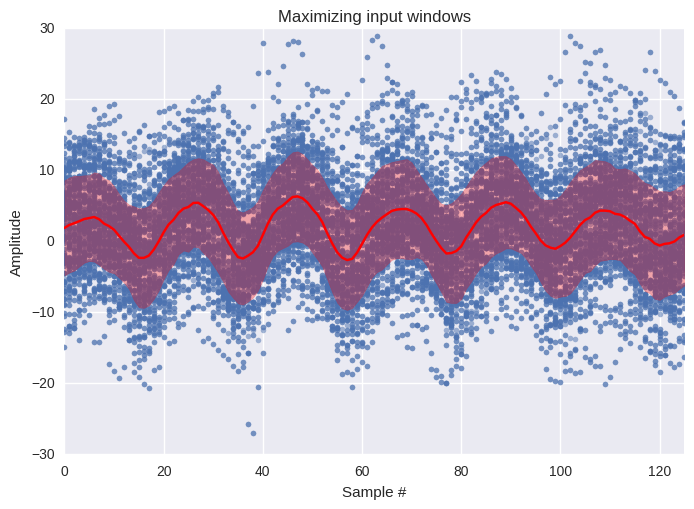

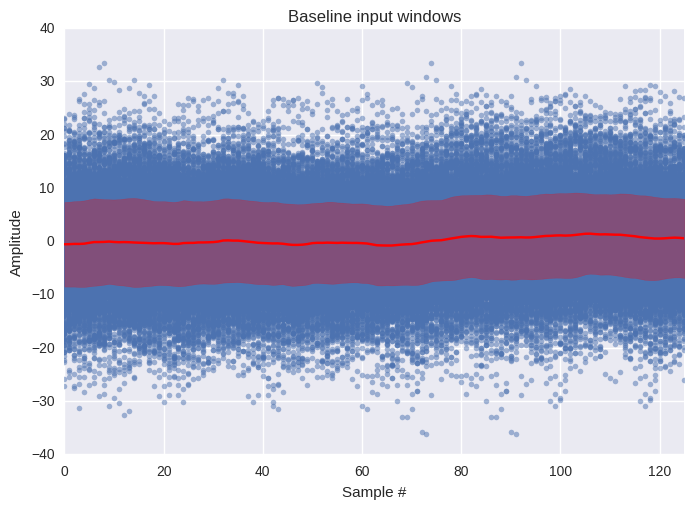

In [49]:
plot_channel_avg(X_RF_cropped,48,'Maximizing input windows')
plot_channel_avg(X_baseline,48,'Baseline input windows')

# Layer 22

Analysis of filters in Layer 22

In [50]:
filename = 'Layer22_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_22 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [155  70  85   7 183]


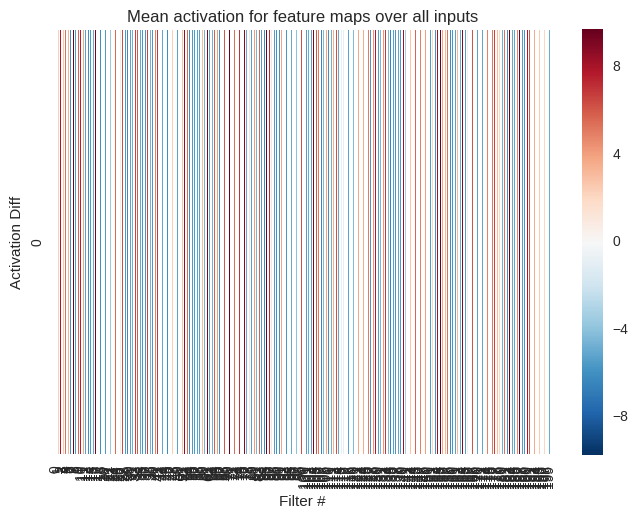

In [51]:
plot_max_filters(RF_data_22)

<b>Filter to look at</b> (index in Max filters)

In [52]:
filt = 1

In [53]:
n_chans = RF_data_22.results[cl].n_chans
sampling_rate = RF_data_22.results[cl].sampling_rate
sensor_names = RF_data_22.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_22,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

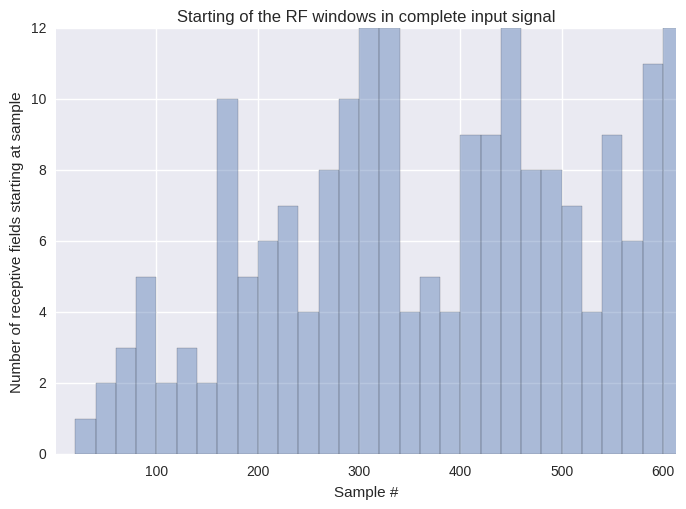

In [54]:
plot_RF_starts(RF_data_22,X_baseline.shape[2])

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [55]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.493000  p 0.000000  : FFT 12.2739018088 C3
Score 0.477000  p 0.000000  : FFTc 5.81395348837 C3
Score 0.471000  p 0.000000  : FFT 11.6279069767 C3
Score 0.455000  p 0.000000  : Phasec 0.645994832041 FCz
Score 0.455000  p 0.000000  : FFT 11.6279069767 CCP5h
Score 0.454000  p 0.000000  : FFT 12.2739018088 CCP3h
Score 0.454000  p 0.000000  : Phasec 0.645994832041 CPP3h
Score 0.436000  p 0.000000  : Phasec 0.645994832041 FCC1h
Score 0.428000  p 0.000000  : Phasec 0.645994832041 P3
Score 0.427000  p 0.000000  : FFT 12.9198966408 C3
Score 0.423000  p 0.000000  : FFT 11.6279069767 CCP3h
Score 0.419000  p 0.000000  : Phasec 0.645994832041 P1
Score 0.412000  p 0.000000  : Phasec 0.645994832041 CPP5h
Score 0.406000  p 0.000000  : FFTc 5.81395348837 CCP3h
Score 0.405000  p 0.000000  : FFT 11.6279069767 C4
Score 0.405000  p 0.000000  : Phasec 0.645994832041 Fz
Score 0.403000  p 0.000000  : Phasec 0.645994832041 FC1
Score 0.401000  p 0.000000  : FFT 10.9819121447 C4
Score 0.399000  p 0.00000

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

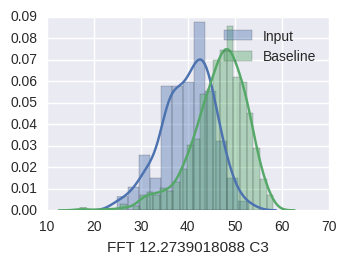

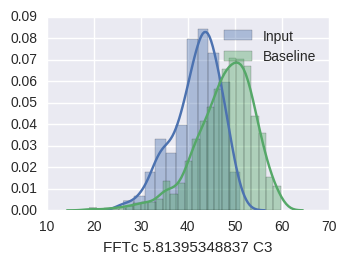

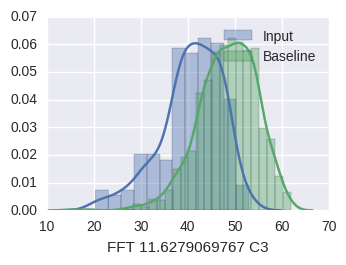

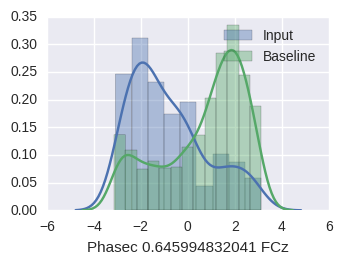

In [56]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

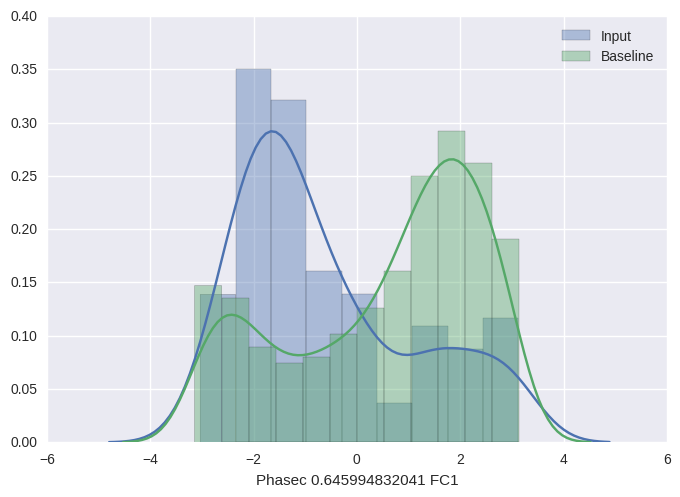

In [57]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[16])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [58]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [19, 55]] ['FFTc', [9, 55]] ['FFT', [18, 55]] ['Phasec', [0, 36]]
 ['FFT', [18, 64]] ['FFT', [19, 65]] ['Phasec', [0, 83]]
 ['Phasec', [0, 46]] ['Phasec', [0, 93]] ['FFT', [20, 55]]]


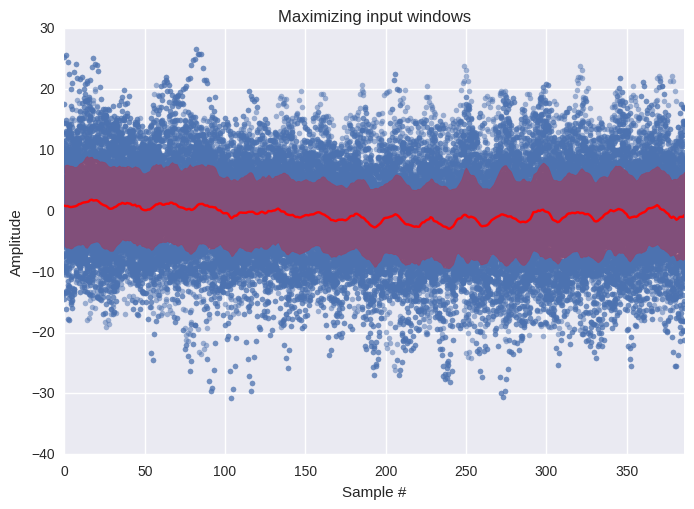

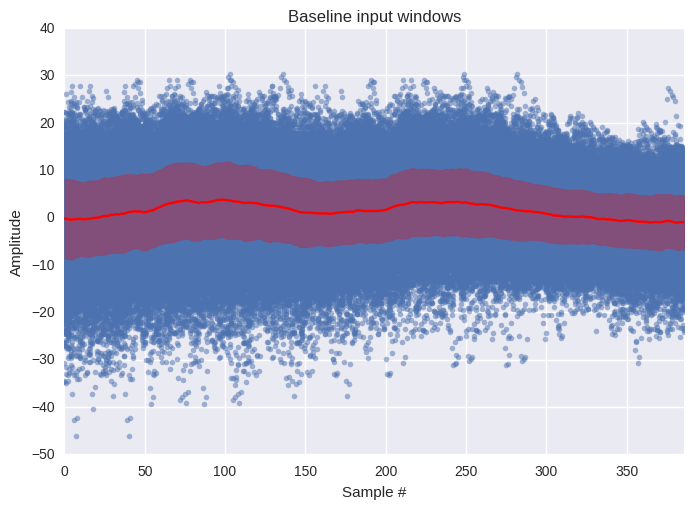

In [59]:
plot_channel_avg(X_RF_cropped,83,'Maximizing input windows')
plot_channel_avg(X_baseline,83,'Baseline input windows')

# Layer 28

Analysis of filters in Layer 28

In [60]:
filename = 'Layer28_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_28 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [0 1 2 3]


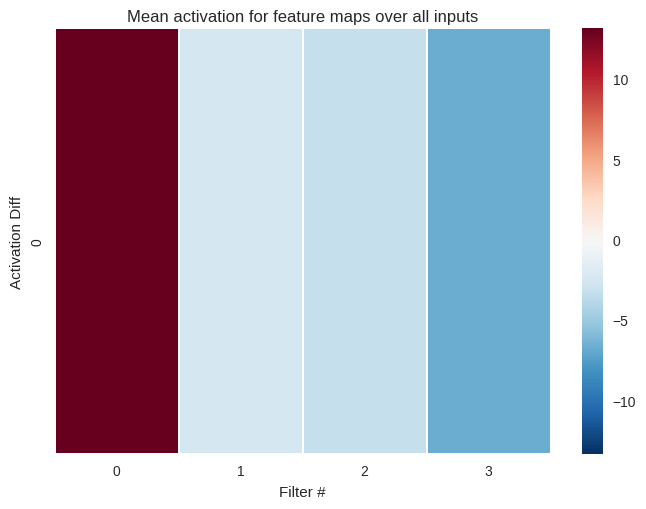

In [61]:
plot_max_filters(RF_data_28)

<b>Filter to look at</b> (index in Max filters)

In [62]:
filt = 1

In [63]:
n_chans = RF_data_28.results[cl].n_chans
sampling_rate = RF_data_28.results[cl].sampling_rate
sensor_names = RF_data_28.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_28,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

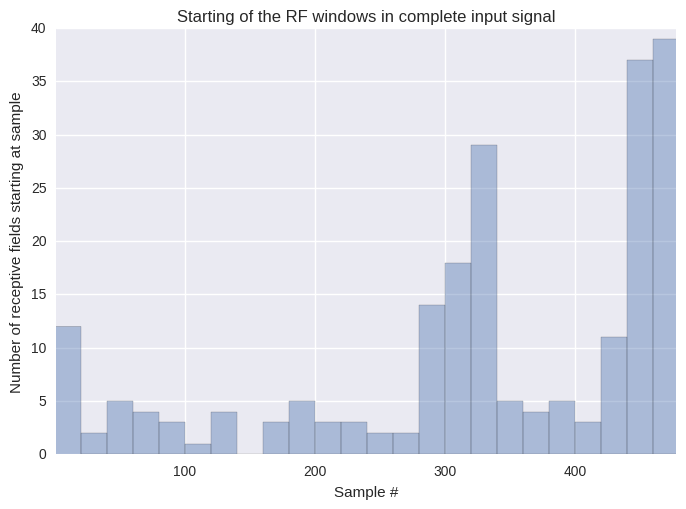

In [64]:
plot_RF_starts(RF_data_28,X_baseline.shape[2])

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [65]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.474776  p 0.000000  : FFT 11.9731800766 C3
Score 0.426664  p 0.000000  : FFTc 6.22605363985 C3
Score 0.413140  p 0.000000  : FFT 11.4942528736 C3
Score 0.408645  p 0.000000  : FFT 12.4521072797 C3
Score 0.407084  p 0.000000  : FFT 12.9310344828 C3
Score 0.406570  p 0.000000  : FFT 11.9731800766 CCP3h
Score 0.403607  p 0.000000  : Phasec 0.478927203065 FCz
Score 0.394206  p 0.000000  : Phasec 0.95785440613 FC3
Score 0.393028  p 0.000000  : FFTc 5.74712643678 C3
Score 0.391720  p 0.000000  : FFT 11.4942528736 CCP3h
Score 0.383551  p 0.000000  : Phasec 0.95785440613 PO3
Score 0.382860  p 0.000000  : Phasec 0.478927203065 FC1
Score 0.380495  p 0.000000  : Phasec 0.95785440613 FCC3h
Score 0.376832  p 0.000000  : FFT 11.0153256705 C3
Score 0.376664  p 0.000000  : FFT 11.9731800766 FCC3h
Score 0.372393  p 0.000000  : FFT 12.4521072797 CCP3h
Score 0.369374  p 0.000000  : Phasec 0.95785440613 CPP5h
Score 0.367645  p 0.000000  : Phasec 0.95785440613 P1
Score 0.365972  p 0.000000  : Phase

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

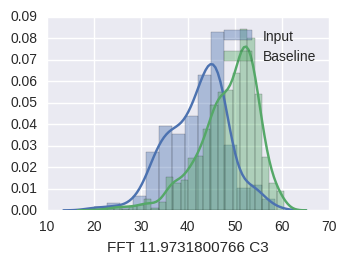

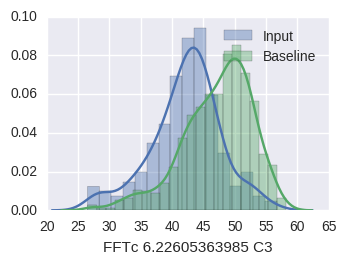

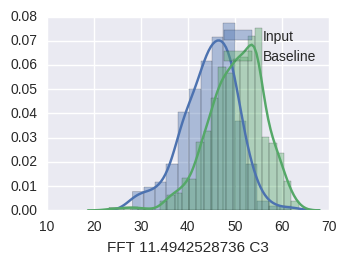

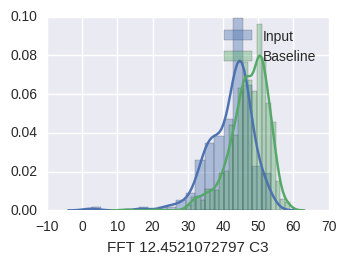

In [66]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

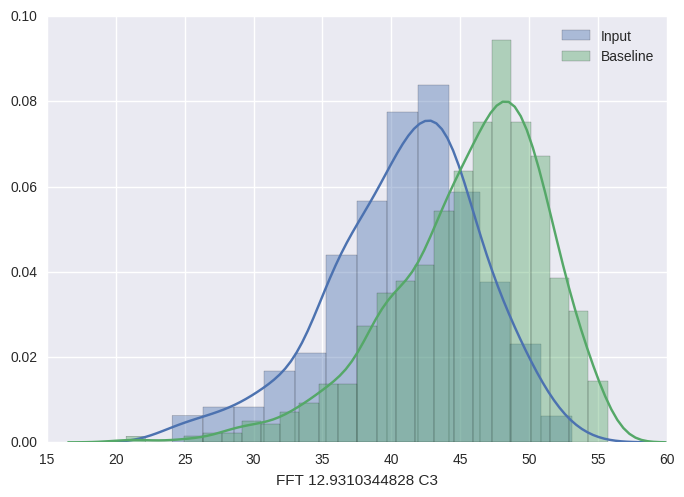

In [67]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[4])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [68]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [25, 55]] ['FFTc', [13, 55]] ['FFT', [24, 55]] ['FFT', [26, 55]]
 ['FFT', [27, 55]] ['FFT', [25, 65]] ['Phasec', [0, 36]]
 ['Phasec', [1, 34]] ['FFTc', [12, 55]] ['FFT', [24, 65]]]


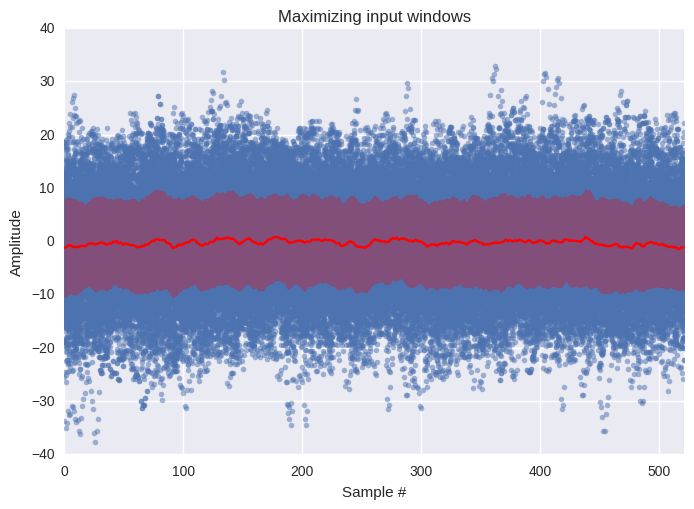

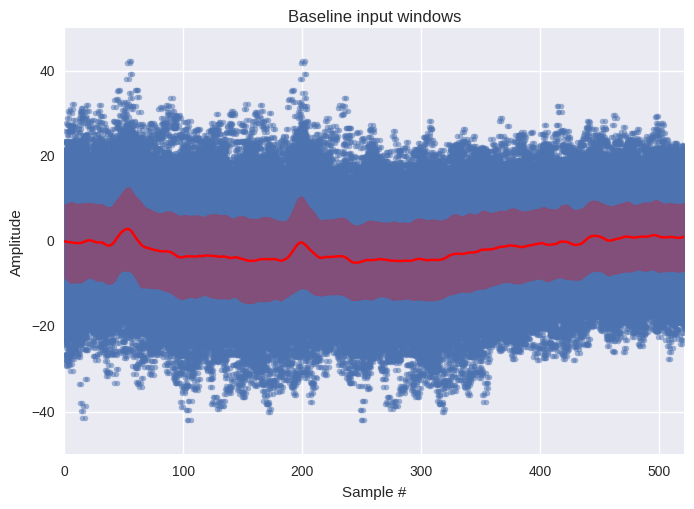

In [69]:
plot_channel_avg(X_RF_cropped,36,'Maximizing input windows')
plot_channel_avg(X_baseline,36,'Baseline input windows')